# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision min)

We've seen the power of transfer learning feature extraction and fine tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

In [1]:
# Check to see of we're using a GPU
!nvidia-smi

Fri Sep 29 15:06:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 522.30       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P0    23W / 170W |    485MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

2023-09-29 15:06:56.235357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, sot let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the imag_data_modification notebook.

In [4]:
assets_dir = "assets"

In [6]:
import os
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
# unzip_data(os.path.join(assets_dir, "101_food_classes_10_percent.zip"))

In [7]:
train_dir = os.path.join(assets_dir, "101_food_classes_10_percent", "train")
test_dir = os.path.join(assets_dir, "101_food_classes_10_percent", "test")

In [8]:
# How many iamges/classes are there?
walk_through_dir(os.path.join(assets_dir, "101_food_classes_10_percent"))

There are 2 directories and 0 images in 'assets/101_food_classes_10_percent'.
There are 101 directories and 0 images in 'assets/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in 'assets/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in 'assets/101_food_classes_

There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in 'assets/101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories 

In [9]:
# Steup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                       label_mode="categorical",
                                                                       image_size=IMG_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       label_mode="categorical",
                                                       image_size=IMG_SIZE,
                                                       shuffle=False) # don't shuffle test data fo prediction analysis

Found 7575 files belonging to 101 classes.


2023-09-29 15:07:31.850937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 15:07:31.888690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 15:07:31.888922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 15:07:31.891877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 15:07:31.892093: I tensorflow/compile

Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layers to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validat on 15% of the test data, to save epoch time)

In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [12]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
#     layers.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [14]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  multiple                  0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [17]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5, # fit for 5 epochs to keep experiments quick
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                          callbacks=[checkpoint_callback])

Epoch 1/5


2023-09-29 15:34:59.213880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-29 15:35:01.807681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-29 15:35:01.896601: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7cdea90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-29 15:35:01.896644: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-09-29 15:35:01.955688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/237 [..............................] - ETA: 44:15 - loss: 4.6457 - accuracy: 0.0312

2023-09-29 15:35:02.262956: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 56s 191ms/step - loss: 3.3738 - accuracy: 0.2688 - val_loss: 2.5100 - val_accuracy: 0.4396
Epoch 2/5
237/237 [==============================] - 43s 181ms/step - loss: 2.2060 - accuracy: 0.4939 - val_loss: 2.0157 - val_accuracy: 0.5175
Epoch 3/5
237/237 [==============================] - 42s 175ms/step - loss: 1.8328 - accuracy: 0.5644 - val_loss: 1.8732 - val_accuracy: 0.5220
Epoch 4/5
237/237 [==============================] - 41s 171ms/step - loss: 1.6117 - accuracy: 0.6028 - val_loss: 1.8080 - val_accuracy: 0.5305
Epoch 5/5
237/237 [==============================] - 39s 164ms/step - loss: 1.4584 - accuracy: 0.6432 - val_loss: 1.7418 - val_accuracy: 0.5453


In [18]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 48s 61ms/step - loss: 1.5858 - accuracy: 0.5840


[1.585768222808838, 0.5839999914169312]

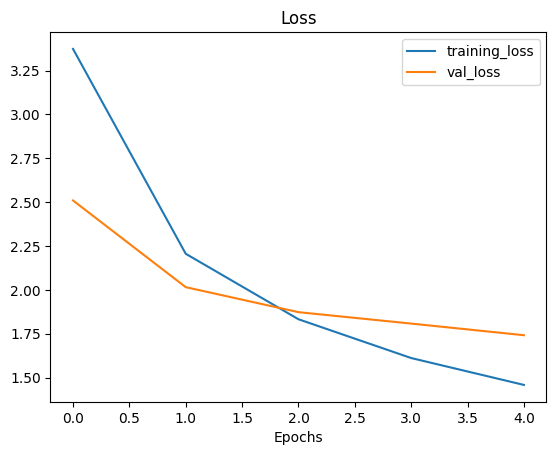

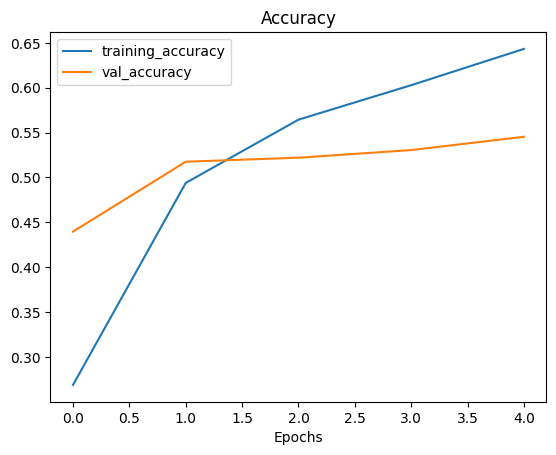

In [19]:
plot_loss_curves(history_all_classes_10_percent)

## Fin tuning

In [20]:
# Unfreez all of the layers in base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [21]:
# Recompile model with lower learning rate its typically best practice to lower the learning rate when fine tuning
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
             metrics=["accuracy"])

In [22]:
# What layers in them model are trainbale
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [23]:
# Check which layers are trainable in our base mode
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [24]:
# Fine tune for more 5 epochs
fine_tune_epochs = 10 # model has already done 5 epohcs (feature extraction), this is the total number of epochs we're after (5+5)

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 151s 604ms/step - loss: 1.2086 - accuracy: 0.6838 - val_loss: 1.7646 - val_accuracy: 0.5405
Epoch 6/10
237/237 [==============================] - 99s 415ms/step - loss: 1.0992 - accuracy: 0.7030 - val_loss: 1.7215 - val_accuracy: 0.5506
Epoch 7/10
237/237 [==============================] - 81s 340ms/step - loss: 1.0185 - accuracy: 0.7262 - val_loss: 1.7199 - val_accuracy: 0.5540
Epoch 8/10
237/237 [==============================] - 68s 284ms/step - loss: 0.9469 - accuracy: 0.7488 - val_loss: 1.7181 - val_accuracy: 0.5524
Epoch 9/10
237/237 [==============================] - 62s 262ms/step - loss: 0.8918 - accuracy: 0.7632 - val_loss: 1.7042 - val_accuracy: 0.5553
Epoch 10/10
237/237 [==============================] - 59s 248ms/step - loss: 0.8368 - accuracy: 0.7744 - val_loss: 1.7377 - val_accuracy: 0.5501


In [25]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 42s 53ms/step - loss: 1.4964 - accuracy: 0.6044


[1.4964460134506226, 0.6044356226921082]

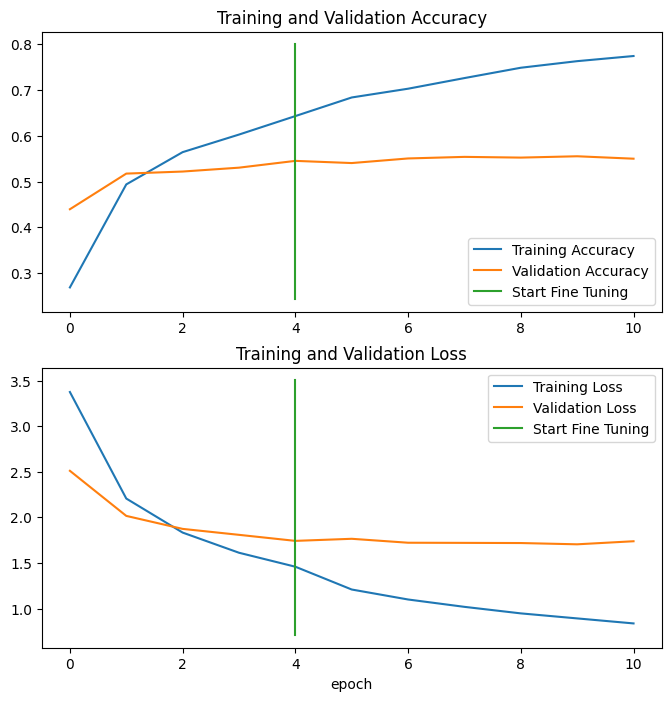

In [26]:
# Compare the histories of feature extraction mdoel with fine tuning model
compare_historys(history_all_classes_10_percent,
                history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [27]:
# Save our fine tuned model
model.save("101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


In [29]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model")

KeyboardInterrupt: 

In [ ]:
# Evaluate loaded model and compare performance to pre saved model
loaded_model_results = loaded_model.evaluate(test_data)

## Evaluating the preformance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong. 

In [31]:
# Download pretrained model (one the was prepared earlier, so all predictions are similar)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [32]:
# unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [30]:
# Load in saved model
model = tf.keras.models.load_model(os.path.join(assets_dir, "06_101_food_class_10_percent_saved_big_dog_model"))

In [33]:
# Evaluate loaded model the one we just downloaed
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 46s 56ms/step - loss: 1.8025 - accuracy: 0.6077


[1.8025290966033936, 0.6077227592468262]

## Making predictions with our trained model

In [34]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 43s 53ms/step


In [35]:
len(test_data)

790

In [36]:
790 * 32

25280

In [37]:
# How many predictions are there?
len(preds_probs)

25250

In [38]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [39]:
# Let's see what the fist 10 predictions look like
preds_probs[:10]

array([[5.94695322e-02, 3.56723581e-06, 4.13260236e-02, ...,
        1.42017531e-09, 8.35453611e-05, 3.08134686e-03],
       [9.63608503e-01, 1.38414558e-09, 8.51073943e-04, ...,
        5.48056669e-05, 7.84217049e-12, 9.83601423e-10],
       [9.59439158e-01, 3.25356741e-05, 1.48666813e-03, ...,
        7.15245960e-07, 5.49242884e-07, 4.00501449e-05],
       ...,
       [4.73309129e-01, 1.29077620e-07, 1.47382554e-03, ...,
        5.97189472e-04, 6.70981754e-05, 2.35287534e-05],
       [4.47014496e-02, 4.74402071e-07, 1.22075796e-01, ...,
        6.34743583e-06, 7.53193899e-06, 3.68984859e-03],
       [7.24721134e-01, 1.92946148e-09, 5.21786424e-05, ...,
        1.22232910e-03, 1.57463909e-09, 9.62884151e-05]], dtype=float32)

In [41]:
# What does the first prediction probability look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9469532e-02, 3.5672358e-06, 4.1326024e-02, 1.0592467e-09,
        8.1479694e-09, 8.5833634e-09, 8.0741216e-07, 8.4910801e-07,
        1.9790054e-05, 7.9996227e-07, 3.1683156e-09, 9.8298369e-07,
        2.8390216e-04, 7.7835965e-10, 7.3986675e-04, 3.8812577e-05,
        6.4626456e-06, 2.4949863e-06, 3.7831422e-05, 2.0613223e-07,
        1.5554946e-05, 8.1306518e-07, 2.6200901e-06, 2.0277083e-07,
        8.3591658e-07, 5.4028019e-06, 3.7439470e-06, 1.3163877e-08,
        2.7575770e-03, 2.7950638e-05, 6.7963585e-10, 2.5432992e-05,
        1.6699459e-04, 7.5934198e-10, 4.0433896e-04, 1.3045848e-08,
        1.7850465e-06, 1.4383716e-06, 2.3167014e-02, 8.2369655e-07,
        8.6145354e-07, 1.7050521e-06, 7.0404831e-06, 1.8575340e-08,
        2.8593416e-07, 8.0282098e-06, 2.0668508e-06, 1.8605949e-07,
        3.3567659e-08, 3.1694039e-04, 1.0493151e-05, 8.5340076e-07,
        8.4756041e-01, 1.0537958e-05, 4.3955126e-07, 3.7121361e-05,
        3.5136814e-05, 3.2508142e-05, 6.7490706e

Our mdoel outputs prediction probability array (with N nubmer of variables, where N is the number of classes) for each to the predict method.

In [42]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of predcition probabilities fo sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of predcition probabilities fo sample 0: 101
What prediction probability sample 0 looks like:
 [5.9469532e-02 3.5672358e-06 4.1326024e-02 1.0592467e-09 8.1479694e-09
 8.5833634e-09 8.0741216e-07 8.4910801e-07 1.9790054e-05 7.9996227e-07
 3.1683156e-09 9.8298369e-07 2.8390216e-04 7.7835965e-10 7.3986675e-04
 3.8812577e-05 6.4626456e-06 2.4949863e-06 3.7831422e-05 2.0613223e-07
 1.5554946e-05 8.1306518e-07 2.6200901e-06 2.0277083e-07 8.3591658e-07
 5.4028019e-06 3.7439470e-06 1.3163877e-08 2.7575770e-03 2.7950638e-05
 6.7963585e-10 2.5432992e-05 1.6699459e-04 7.5934198e-10 4.0433896e-04
 1.3045848e-08 1.7850465e-06 1.4383716e-06 2.3167014e-02 8.2369655e-07
 8.6145354e-07 1.7050521e-06 7.0404831e-06 1.8575340e-08 2.8593416e-07
 8.0282098e-06 2.0668508e-06 1.8605949e-07 3.3567659e-08 3.1694039e-04
 1.0493151e-05 8.5340076e-07 8.4756041e-01 1.0537958e-05 4.3955126e-07
 3.7121361e-05 3.5136814e-05 3.2508142e-05 6.7490706e-05 1.2783565e-08
 2.6349692e-10 1.0302981e-05 8.5243053e-05 1.0

In [43]:
test_data.class_names[52]

'gyoza'

In [45]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do the look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [46]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evalute them, we need to compare them to the original test dataset

In [47]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [48]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
    
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's preditions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [50]:
results_downloaded_model

[1.8025290966033936, 0.6077227592468262]

In [53]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077227722772277

In [54]:
# Does this metrics come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [55]:
from helper_functions import make_confusion_matrix

In [56]:
# Get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [61]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
            

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically) ##
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [62]:
make_confusion_matrix(y_labels,
                     pred_classes,
                     class_names,
                     figsize=(100,100),
                     text_size=20)

## Let's keep the evaluataion train going, time for classification report

Scikit-learn has a helpful function for aquiring many different classifiaction metrics per class (e.g. precision, recall and F1) called classification report, let's try it out. 

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,
                           pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.74      0.44      0.55       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numberso above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.
How about we create a visualization to get better understanding?

In [65]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7364864864864865,
  'recall': 0.436,
  'f1-score': 0.5477386934673367,
  'support': 250.0},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250.0},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'suppo

In [67]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores

In [69]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
        
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5477386934673367,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42689075630252105,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45325779036827196,
 'chocolate_mousse': 0.3261648745519713,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee': 0.7494824016

In [73]:
# Turn f1-socres into datafraem for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)


<Axes: >

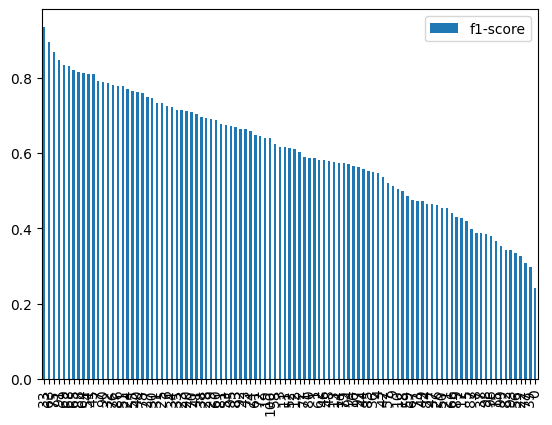

In [76]:
f1_scores.plot(kind="bar")

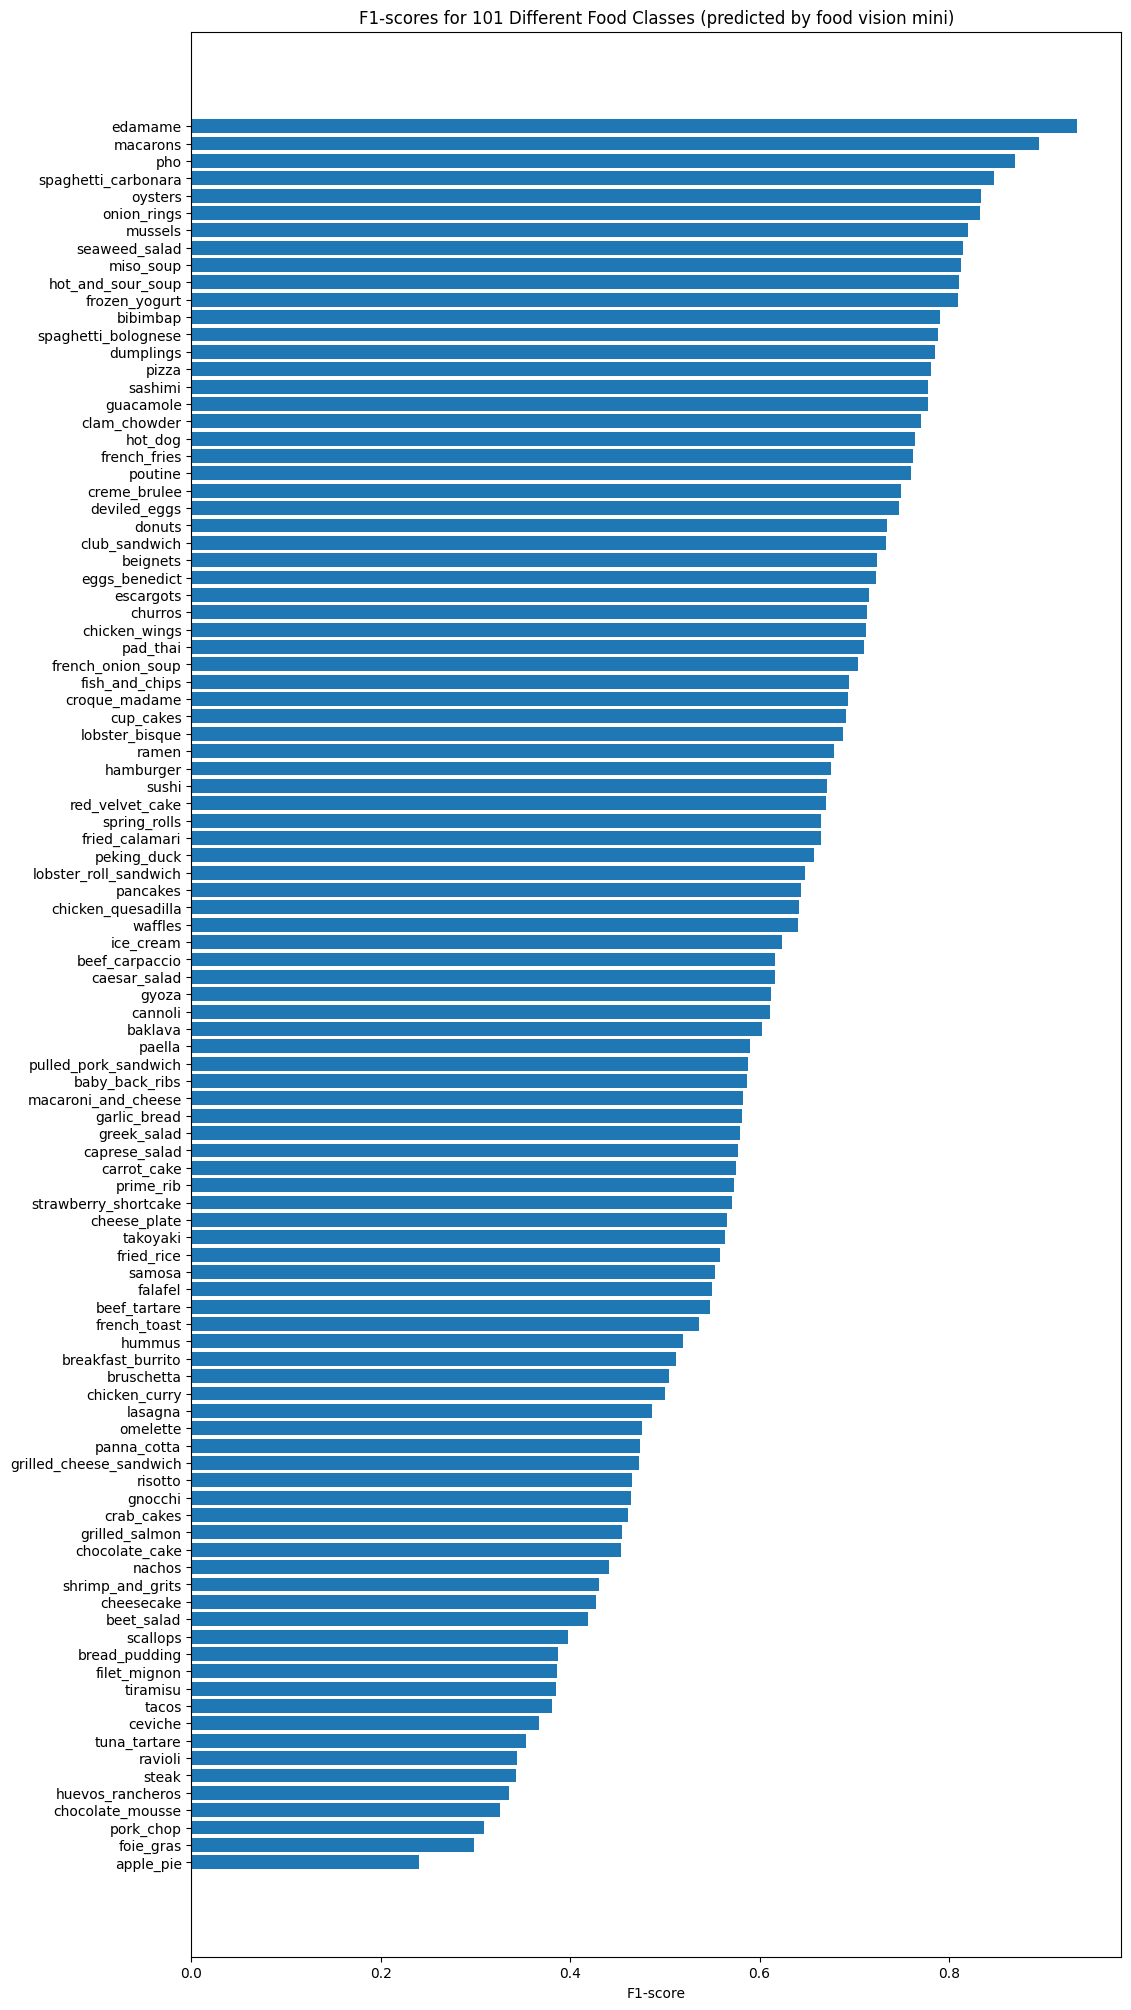

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis();